### Voting Classifier
- 다른 알고리즘 적용
- 다수결로 예측

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
# 데이터 로딩
cancer = load_breast_cancer() # 내장 데이터들은 형식이 모두 동일

data_df = pd.DataFrame(
      cancer.data
    , columns=cancer.feature_names
)

In [ ]:
# 항상 데이터프레임의 정보는 확인해주자
data_df.info()

In [8]:
# 데이터 분리
X_train, X_test, y_train, y_test = \
train_test_split(
      cancer.data
    , cancer.target
    , test_size=0.2
    , random_state=156
)

In [16]:
# 모델 객체 생성
lr_clf = LogisticRegression(max_iter=10000)
knn_clf = KNeighborsClassifier(n_neighbors=8)

# Voting 객체 생성
vo_clf = VotingClassifier(
       #  [(내부이름, 모델객체),(내부이름, 모델객체)]
      estimators=[('LR',lr_clf),('KNN',knn_clf)] # 1. 사용할 알고리즘(모델)
    , voting='soft'# 2. 보팅 방식(Hard, Soft)
)

In [17]:
# 학습, 예측, 성능 평가(정확도)
vo_clf.fit(X_train, y_train)

pred = vo_clf.predict(X_test)
accu = accuracy_score(y_test, pred)
accu

0.9473684210526315

In [13]:
sr_y_train = pd.Series(y_train)
sr_y_train.value_counts()

1    280
0    175
dtype: int64

In [18]:
clf_obj = [lr_clf, knn_clf]
for clf in clf_obj:
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accu = accuracy_score(y_test, pred)
    class_name = clf.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accu))

LogisticRegression 정확도 : 0.9649
KNeighborsClassifier 정확도 : 0.9386


### Random Forest

In [3]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [11]:
# HAR 데이터셋을 가져오는 function
def get_human_dataset():
    # 피처명
    feature_name_df = \
    pd.read_csv(
          './data/UCI HAR Dataset/features.txt'
        , sep='\s+'
        , header=None
        , names=['column_index', 'column_name']
    )
    
    # 피쳐명 추출
    feature_name = feature_name_df.iloc[:,1].values.tolist() # ndarray 를 list로 변환
    
    X_train = pd.read_csv(
          './data/UCI HAR Dataset/train/X_train.txt'
        , sep='\s+'
        , header=None
#         , names=feature_name # 컬럼명 지정 -- ndarray 형식은 들어갈 수 없음!!!
    )
    
    X_test = pd.read_csv(
          './data/UCI HAR Dataset/test/X_test.txt'
        , sep='\s+'
        , header=None
#         , names=feature_name
    )
    
    y_train = pd.read_csv(
          './data/UCI HAR Dataset/train/y_train.txt'
        , sep='\s+'
        , header=None
        , names=['action']
    )
    
    y_test = pd.read_csv(
          './data/UCI HAR Dataset/test/y_test.txt'
        , sep='\s+'
        , header=None
        , names=['action']
    )
    
    return X_train, X_test, y_train, y_test, feature_name

In [12]:
X_train, X_test, y_train, y_test, feature_name = get_human_dataset()

In [17]:
X_train.columns = feature_name
X_test.columns = feature_name

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [20]:
# 모델 객체 생성
rf_clf = RandomForestClassifier(random_state=0)

# 학습
rf_clf.fit(X_train,y_train)

# 예측값
pred = rf_clf.predict(X_test)

# 성능 평가
accu = accuracy_score(y_test, pred)

# 성능 출력
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accu))

랜덤 포레스트 정확도 : 0.9253


In [21]:
# GridSearchCV : 베스트 파라미터 추출
from sklearn.model_selection import GridSearchCV

params = {
      'n_estimators' : [100] # default : 10
    , 'max_depth' : [6,8,10,12] # 가지치기 => overfitting 방지
    , 'min_samples_leaf' : [8,12,18] # 가지치기 => overfitting 방지
    , 'min_samples_split' : [8,16,20] # 가지치기 => overfitting 방지
}

# 랜덤 포레스트 객체 생성
rf_clf = RandomForestClassifier(
      random_state=0
    , n_jobs=-1 # 전체 코어 사용 (병렬처리)
)

# GridSearchCV 객체 생성
grid_cv = GridSearchCV(
      rf_clf # 적용할 알고리즘(모델)
    , param_grid=params # 적용할 하이퍼 파라미터
    , cv=2 # 교차 검증할 데이터 셋
    , n_jobs=-1 # 전체 코어 사용 (병렬처리)
)

In [22]:
# 학습
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20],
                         'n_estimators': [100]})

In [23]:
# Best parameter
grid_cv.best_params_

{'max_depth': 10,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 100}

In [24]:
# Best Score
grid_cv.best_score_

0.9179815016322089

In [26]:
# 확장

rf_clf1 = RandomForestClassifier(
      n_estimators=300
    , max_depth=10
    , min_samples_leaf=8
    , min_samples_split=8
    , random_state=0
)
rf_clf1.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=8,
                       n_estimators=300, random_state=0)

In [27]:
pred = rf_clf1.predict(X_test)

accu = accuracy_score(y_test, pred)
print('앙상블 랜덤 포레스트 정확도 : {0:.4f}'.format(accu))

앙상블 랜덤 포레스트 정확도 : 0.9165


In [28]:
# 피처 중요도 출력 : 561개 피처 -> TOP20
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
# 피처 중요도 추출 - 학습한 객체
type(rf_clf1.feature_importances_)

numpy.ndarray

In [34]:
ftr_imp

array([7.66830533e-05, 1.55108248e-04, 7.50074368e-05, 7.17884758e-03,
       1.96620961e-04, 2.06442129e-04, 3.22956324e-03, 3.21980543e-04,
       2.28984098e-04, 9.04272891e-03, 1.32616538e-04, 1.32368212e-04,
       2.94703130e-04, 1.18378751e-04, 1.23486918e-04, 4.90144138e-04,
       4.77627555e-03, 2.65853003e-04, 2.81876566e-04, 1.95515407e-03,
       1.86928745e-04, 1.74392628e-04, 1.22782025e-03, 9.37013684e-05,
       2.16185561e-04, 1.06768642e-04, 4.82331868e-05, 5.25599737e-05,
       8.96993733e-05, 1.10738368e-04, 4.60237122e-05, 4.03838481e-05,
       1.07309054e-04, 6.50333000e-05, 5.51415166e-05, 5.16006595e-05,
       8.60156938e-05, 5.77401271e-03, 7.61995014e-04, 2.65217763e-03,
       2.71256255e-02, 3.09859024e-02, 9.26969485e-03, 2.13319991e-03,
       1.17409402e-03, 2.66265583e-04, 1.40499009e-03, 1.03313224e-03,
       2.48777608e-04, 2.76484181e-02, 2.45522042e-02, 1.23520886e-02,
       3.24873637e-02, 2.91880885e-02, 8.58912448e-03, 4.64208742e-03,
      

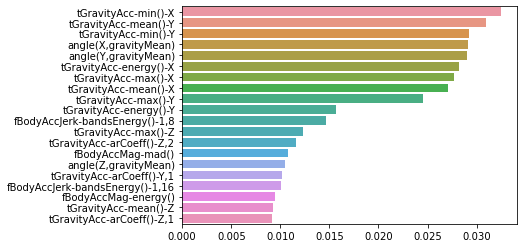

In [30]:
# 피처 추출
ftr_imp = rf_clf1.feature_importances_

# 시리즈 타입으로 변환
ftr_imp_sr = pd.Series(
      ftr_imp
    , index = X_train.columns
)

# 중요도 정렬 후 상위 20개 추출
ftr_top20 = ftr_imp_sr.sort_values(ascending=False)[:20]

# 시각화
sns.barplot(
      x=ftr_top20
    , y=ftr_top20.index
)


### GBM (Gradient Boosting Machine)

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
import time

In [33]:
# 시작시간
start_time = time.time()

# 모델 객체 생성
gb_clf = GradientBoostingClassifier(random_state=0)

# 학습
gb_clf.fit(X_train, y_train)

# 예측
pred = gb_clf.predict(X_test)

# 평가
gb_accu = accuracy_score(y_test, pred)

# 걸린 시간
end_time = time.time() - start_time

# 결과 출력
print('GBM 정확도 : {0:.4f}'.format(gb_accu))
print('GBM 수행시간 : {0:.1f}'.format(end_time))

GBM 정확도 : 0.9389
GBM 수행시간 : 670.6


### XGBoost(eXtra Gradient Boost)
- 과적합 규재를 통해 속도와 성능을 향상 ( GBM의 단점 보완 )
- 파라미터에 민감해져서 튜닝이 어려워짐

In [37]:
import xgboost as xgb
from xgboost import XGBClassifier

### Native XGBoost 적용
- 데이터 셋 : 유방암 데이터 셋

In [38]:
import numpy as np
import pandas as pd
import xgboost as xgb

from xgboost import plot_importance
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [40]:
# 데이터 추출
dataset = load_breast_cancer()
X_features = dataset.data # 데이터
y_label = dataset.target # 답

In [41]:
# 데이터 프레임 생성
cancer_df = pd.DataFrame(
      data=X_features
    , columns=dataset.feature_names # 컬럼명
)
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [42]:
# 기존데이터프레임에 답 추가
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [44]:
# 악성, 양성 : 이진 분류
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']


KeyError: 'target'

In [45]:
pred

array([5, 5, 5, ..., 2, 2, 2], dtype=int64)